# CP Decomposition

임의의 Rank $k$를 설정하여 컴포넌트들의 외적을 구한다.<br>
이때 i번째 컴포넌트들 차원은 ($dim{X_i}$, r)이 된다.<br>
이 외적은 rank 1 벡터들의 외적의 합으로 Tensor를 표현할 수 있다.

`construct`함수에서 이 외적의 표현을 살펴보면 `A`와 `B`는 외적을 수행하지만 `C`는 코드상 표기로 내적이 수행됨을 확인 할 수 있는데, 이는 사실 A와 B의 외적 텐서의 마지막 차원을 늘린 뒤에 C의 내적을 수행하는 것이므로 A,B,C를 외적하는 것과 같은 연산이 수행된다.

In [42]:
import torch

# 기본 타겟이 될 텐서X와 차원 dim 정의
dim = [3,4,5]
X = torch.randn((dim))

target_rank = 7

In [43]:
def func(rank):
    RANK = rank

    # X를 rank 개수의 1-dim 벡터로 Decompose
    A = torch.randn((dim[0], RANK), requires_grad=True)
    B = torch.randn((dim[1], RANK), requires_grad=True)
    C = torch.randn((dim[2], RANK), requires_grad=True)

    # A, B, C로부터 Tensor X를 Construct
    def construct(A,B,C):
        """Given Matrices A, B, C construct 3D Tensor
                A : i, r
                B: j, r
                C : k, r"""
        X_tilde = 0
        for i in range(RANK):
            X_tilde += torch.outer(A[:,i], B[:,i]).unsqueeze(2)*C[:,i]
        return X_tilde

    def CP_decomposition(original, factors, max_iter=10000, lr=0.01):
        """Minimize Frobenius Norm |X-X_tilde|, Update decomposition factors."""
        opt = torch.optim.Adam(factors, lr=lr)
        losses = []
        for i in range(max_iter):  # 반복횟수 만큼 CP 최소화 수행
            X_tilde = construct(*factors)
            opt.zero_grad()
            loss = torch.mean((original - X_tilde)**2)
            losses.append(loss.item())
            loss.backward()
            opt.step()
        return losses

    losses = CP_decomposition(original=X, factors=[A,B,C])
    
    return losses

In [44]:
loss = []

for i in range(1,target_rank+1):
    loss.append(func(i))

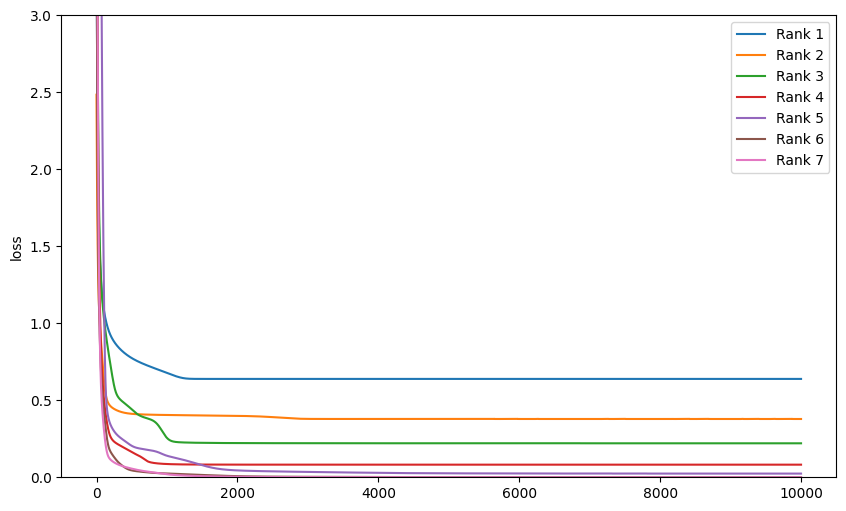

In [51]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

for i in range(target_rank):
    plt.plot(list(range(len(loss[i]))), loss[i], label=f'Rank {i+1}')

plt.ylim(0, 3)

plt.ylabel('loss')

plt.legend()
plt.show()

그래프로 그린 Frobenius Norm의 loss값을 확인해보면, Rank가 커질 수록 loss가 낮아진다. <br>
이는 Rank가 커질수록 기존 텐서와 더 근사해짐을 의미한다. <br>
하지만 Rank가 커지면 decomposition된 컴포넌트들의 크기가 커지므로 메모리, 연산량 등이 증가하기 때문에 이 trade-off를 잘 신경써서 최적의 Rank를 구하는게 중요해 보인다.


# 이미지에 적용해보기

위는 loss를 확인해봤고 이제는 샘플이미지를 대상으로 얼마나 잘 되는지를 확인해보겠다.

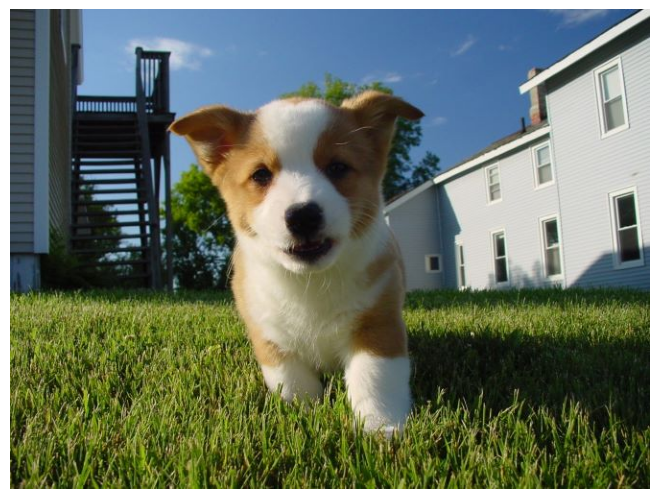

In [79]:
from PIL import Image
import torchvision.transforms as transforms

image_path = "./sample_image.png"
image = Image.open(image_path)

# 샘플 이미지
plt.imshow(image)
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor()           
])
image_tensor = transform(image)

위에서 정의한 CP decomposition 함수와 유사하지만 반환값이 loss가 아닌 image가 나올 수 있도록 수정하겠다.

In [81]:
def func2(rank):

    RANK = rank
    A = torch.randn((image_tensor.shape[0], RANK), requires_grad=True)
    B = torch.randn((image_tensor.shape[1], RANK), requires_grad=True)
    C = torch.randn((image_tensor.shape[2], RANK), requires_grad=True)

    def construct(A,B,C):
        X_tilde = 0
        for i in range(RANK):
            X_tilde += torch.outer(A[:,i], B[:,i]).unsqueeze(2)*C[:,i]
        return X_tilde

    def CP_decomposition(original, factors, max_iter=10000, lr=0.01):
        opt = torch.optim.Adam(factors, lr=lr)
        losses = []
        for i in range(max_iter):  # 반복횟수 만큼 CP 최소화 수행
            X_tilde = construct(*factors)
            opt.zero_grad()
            loss = torch.mean((original - X_tilde)**2)
            losses.append(loss.item())
            loss.backward()
            opt.step()
        
        return construct(*factors)
    
    cp_img = CP_decomposition(image_tensor, [A,B,C])
    return cp_img.permute(1, 2, 0).detach().numpy()

In [108]:
target_rank = [1, 3, 5, 7, 9 ,11]

imgs = []

for r in target_rank:
    imgs.append(func2(r))

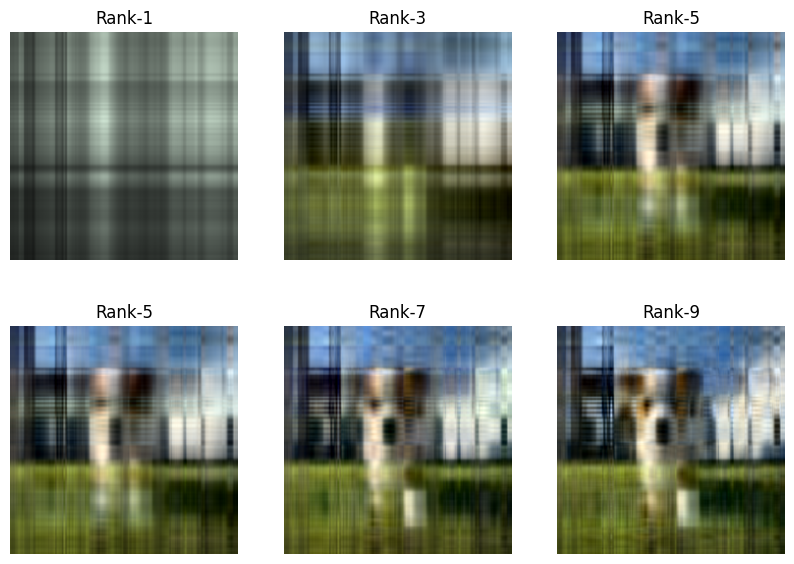

In [111]:
fig, axes = plt.subplots(2, 3, figsize=(10, 7))

for i in range(2):
    for j in range(3):
        axes[i][j].imshow(np.clip(imgs[i*2+j], 0, 1))
        axes[i][j].axis('off')  
        axes[i][j].set_title(f"Rank-{target_rank[i*2+j]}")

rank가 커질 수록 원본 텐서와 점점 유사해짐을 확인할 수 있다.<br>

일반적으로 rank는 1부터 50까지 할당한다고 한다. (너무 커지면 과적합 발생)<br>
따라서 rank-50을 할당하여 복원한 사진을 확인해보고 마무리 하겠다.

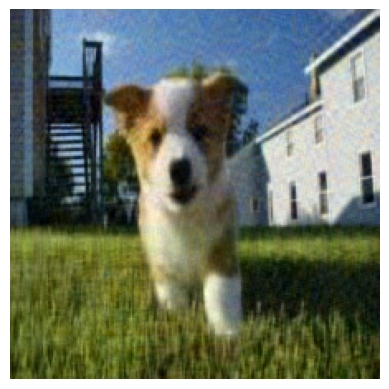

In [116]:
img = func2(50)
plt.imshow(np.clip(img, 0, 1))
plt.axis("off")
plt.show()